<a href="https://colab.research.google.com/github/100jy/dacon_ts_forecasting/blob/main/Normalized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torchcontrib

  Created wheel for torchcontrib: filename=torchcontrib-0.0.2-cp36-none-any.whl size=7531 sha256=fba2aca9386c04b8d720997ce9cda8f2595a42669a31c35667e1ec564e2b6098
  Stored in directory: /root/.cache/pip/wheels/06/06/7b/a5f5920bbf4f12a2c927e438fac17d4cd9560f8336b00e9a99
Successfully built torchcontrib


# 전처리

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import Dataset
import torch.optim.adam
from torchcontrib.optim import SWA
import datetime
import matplotlib.pyplot as plt 
from tqdm import tqdm

In [11]:

train = pd.read_csv("./drive/MyDrive/데이콘/train.csv", encoding = 'euc-kr')

# 시간 관련 변수들
date_time = pd.to_datetime(train.DateTime)
#일자
train['Date'] = date_time.dt.date
train = train.groupby(train['Date']).sum().reset_index()  


def log_trans(x):
  return np.log(1+x)

def minmax(x):
  return (x-x.min())/(x.max()-x.min())


for target in ['사용자', '세션', '신규방문자', '페이지뷰']:
  train[target+'_mean'] = (train[target].rolling(60).mean())
  train[target+'_std'] = (train[target].rolling(60).std())
  

# 요일 혹은 분기정보
date_time = pd.to_datetime(train['Date'])
train['DayOfWeek'] = (date_time.dt.weekday)/6
train['DayOfMon'] = (date_time.dt.day)/31
train['Quarter'] = (date_time.dt.quarter)/4

train['Year'] = ((date_time.dt.year) -2019)
train['Days'] = ((date_time.max() - date_time).dt.days + 1)
train['Days'] /= train['Days'].max()

# 보간해줌
train.iloc[479,1:] = (train.iloc[477,1:] + train.iloc[480,1:]) // 2
train.iloc[478,1:] = (train.iloc[477,1:] + train.iloc[479,1:]) // 2

# ts feature 생성 
for target in ['사용자', '세션', '신규방문자', '페이지뷰']:
    train[f'{target}CumSum'] = train[target].cumsum()

    for k in [3,7,14,21]:
        train[f'{target}RollingMean{k}'] =  minmax(train[target].rolling(k).mean())

    train[f'{target}RollingStd21'] =  minmax(train[target].rolling(21).std().round(0))
    train[f'{target}DaysSince10000'] = (train[f'{target}CumSum'] > 10000) * 1
    train[f'{target}DaysSince100000'] = (train[f'{target}CumSum'] > 100000) * 1

    train[f'{target}RollingMeanDiff2w'] = train[f'{target}RollingMean7'] / (train[f'{target}RollingMean14'] + 1) - 1
    train[f'{target}RollingMeanDiff3w'] = train[f'{target}RollingMean7'] / (train[f'{target}RollingMean21'] + 1) - 1


    train[f'{target}CumSum'] = minmax(train[target].cumsum())

    #normalizing
    train[target] = (train[target] - train[target+'_mean']) / (train[target+'_std'] + 1e-5)
    train[target+'_mean'] = log_trans(train[target+'_mean'])
    train[target+'_std'] = log_trans(train[target+'_std'])
    

# 진행중인 대회수 변수 추가
comp = pd.read_csv("./drive/MyDrive/데이콘/info_competition.csv", encoding = 'euc-kr', index_col=0)
comp = comp.iloc[1:]
comp = comp[comp['participants'] >=  (comp['participants'].mean() / 3)]

# 일자만 남기기
comp['period_start'] = pd.to_datetime(comp['period_start']).dt.date
comp['period_end'] = pd.to_datetime(comp['period_end']).dt.date

train['OnGoingComp'] = [0 for x in range(len(train))]

for start, end in zip(comp['period_start'], comp['period_end']): 
  
  try:
    start_idx = train[start == train['Date']].index[0]
  except:
    start_idx = min(train.index)

  try:
    end_idx = train[end == train['Date']].index[0]
  except:
    end_idx = max(train.index)
  
  for day in range(start_idx, end_idx+1):
    train['OnGoingComp'][train.index == day] += 1

train['OnGoingComp'] = train['OnGoingComp'].rolling(30).mean()
train['OnGoingComp'] /= train['OnGoingComp'].max()
train = train.dropna()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
train

,Date,사용자,세션,신규방문자,페이지뷰,사용자_mean,사용자_std,세션_mean,세션_std,신규방문자_mean,신규방문자_std,페이지뷰_mean,페이지뷰_std,DayOfWeek,DayOfMon,Quarter,Year,Days,사용자CumSum,사용자RollingMean3,사용자RollingMean7,사용자RollingMean14,사용자RollingMean21,사용자RollingStd21,사용자DaysSince10000,사용자DaysSince100000,사용자RollingMeanDiff2w,사용자RollingMeanDiff3w,세션CumSum,세션RollingMean3,세션RollingMean7,세션RollingMean14,세션RollingMean21,세션RollingStd21,세션DaysSince10000,세션DaysSince100000,세션RollingMeanDiff2w,세션RollingMeanDiff3w,신규방문자CumSum,신규방문자RollingMean3,신규방문자RollingMean7,신규방문자RollingMean14,신규방문자RollingMean21,신규방문자RollingStd21,신규방문자DaysSince10000,신규방문자DaysSince100000,신규방문자RollingMeanDiff2w,신규방문자RollingMeanDiff3w,페이지뷰CumSum,페이지뷰RollingMean3,페이지뷰RollingMean7,페이지뷰RollingMean14,페이지뷰RollingMean21,페이지뷰RollingStd21,페이지뷰DaysSince10000,페이지뷰DaysSince100000,페이지뷰RollingMeanDiff2w,페이지뷰RollingMeanDiff3w,OnGoingComp
29,2018-10-08,-1.271524,-1.186865,-0.741490,-1.157055,4.531062,2.943184,4.485421,2.868489,3.487812,2.433943,6.137110,5.238026,0.000000,0.258065,1.0,-1,0.963384,0.006273,0.002279,0.002639,0.005239,0.013188,0.037915,0,0,-0.997375,-0.997395,0.005972,0.002310,0.002349,0.005161,0.012525,0.035748,0,0,-0.997663,-0.997680,0.005744,0.013124,0.009852,0.008853,0.012369,0.023188,0,0,-0.990234,-0.990268,0.001943,0.000329,0.000660,0.001224,0.003418,0.010770,1,0,-0.999341,-0.999342,0.637500
30,2018-10-09,-1.400437,-1.365027,-0.753420,-1.007362,4.454347,3.141387,4.417118,3.063753,3.470190,2.468764,6.055780,5.347263,0.166667,0.290323,1.0,-1,0.962121,0.006335,0.000622,0.000855,0.004014,0.008792,0.027488,0,0,-0.999148,-0.999152,0.006034,0.000840,0.000796,0.003935,0.008382,0.026341,0,0,-0.999207,-0.999211,0.005852,0.013381,0.009255,0.009554,0.009261,0.020290,0,0,-0.990832,-0.990830,0.001954,0.000000,0.000288,0.000970,0.001989,0.005804,1,0,-0.999712,-0.999712,0.640625
31,2018-10-10,0.244008,0.146852,-0.158325,0.473036,4.460970,3.146199,4.418841,3.064733,3.456767,2.470440,6.109882,5.365558,0.333333,0.322581,1.0,-1,0.960859,0.006440,0.000000,0.001004,0.002535,0.006429,0.023697,0,0,-0.998999,-0.999003,0.006133,0.000000,0.000834,0.002430,0.006222,0.022578,0,0,-0.999168,-0.999172,0.005988,0.007463,0.008807,0.010167,0.008754,0.020290,0,0,-0.991281,-0.991269,0.001983,0.000180,0.000532,0.000563,0.001382,0.004283,1,0,-0.999468,-0.999468,0.643750
32,2018-10-11,-0.299304,-0.360359,-0.777392,0.144156,4.451020,3.154144,4.411932,3.073359,3.429368,2.517164,6.112101,5.366267,0.500000,0.354839,1.0,-1,0.959596,0.006529,0.000622,0.000781,0.000444,0.003057,0.010427,0,0,-0.999220,-0.999222,0.006219,0.000420,0.000682,0.000409,0.002879,0.009407,0,0,-0.999318,-0.999320,0.006087,0.006691,0.007912,0.008239,0.004504,0.008696,0,0,-0.992153,-0.992124,0.002008,0.000796,0.000543,0.000151,0.000790,0.002762,1,0,-0.999457,-0.999458,0.646875
33,2018-10-12,1.174650,1.254502,0.428150,0.554926,4.415392,2.905237,4.380239,2.836528,3.410676,2.485808,5.987887,4.879154,0.666667,0.387097,1.0,-1,0.958333,0.006647,0.003937,0.000000,0.000000,0.001387,0.004739,0,0,-1.000000,-1.000000,0.006333,0.003570,0.000000,0.000000,0.001312,0.004704,0,0,-1.000000,-1.000000,0.006247,0.009521,0.007315,0.008327,0.003425,0.005797,0,0,-0.992746,-0.992710,0.002032,0.001462,0.000000,0.000000,0.000174,0.000497,1,0,-1.000000,-1.000000,0.650000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787,2020-11-04,0.609891,0.621805,0.662869,0.411573,8.215856,7.201908,8.204437,7.180130,6.825460,6.033978,11.485836,10.527094,0.333333,0.129032,1.0,1,0.006313,0.985299,1.000000,0.941008,0.910764,0.923425,0.981043,1,1,-0.507523,-0.510764,0.985572,1.000000,0.948846,0.913622,0.925348,0.961430,1,1,-0.504162,-0.507182,0.986276,1.000000,0.938050,0.926725,0.943165,0.863768,1,1,-0.513137,-0.517256,0.984458,1.000000,0.997799,0.912717,0.856685,0.996338,1,1,-0.478335,-0.462591,0.975000
788,2020-11-05,0.317259,0.279553,0.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50857 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50857 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text

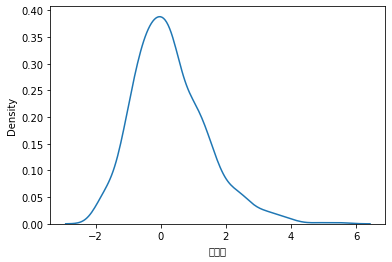

In [12]:
import seaborn as sns
sns.kdeplot(train['사용자'])

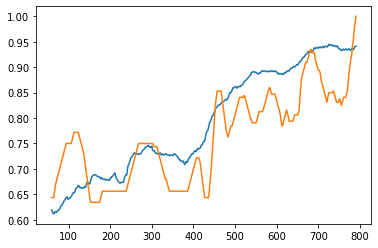

In [13]:
(train['사용자_mean']*0.12).plot()
train['OnGoingComp'].plot()

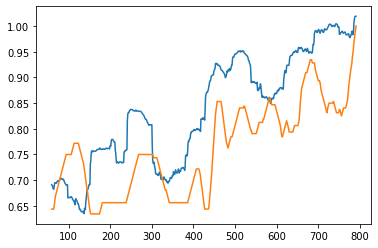

In [14]:
(train['사용자_std']*0.15).plot()
train['OnGoingComp'].plot()

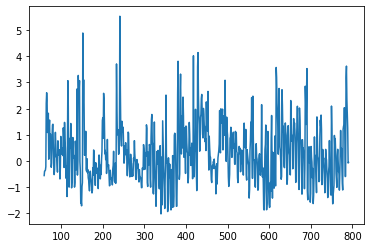

In [15]:
train['사용자'].plot()

# 모델

In [16]:
def make_data(df, window_size=30):
  # in 180
  input_window = window_size
  # out 61 
  output_window = 61

  window_x = np.zeros((df.shape[0] - (input_window + output_window), input_window, df.shape[1]-1))
  window_y = np.zeros((df.shape[0] - (input_window + output_window), output_window, 12))

  for start in range(df.shape[0] - (input_window + output_window)):
      end = start + input_window    
      window_x[start,:, :] = df.iloc[start : end, 1: ].values
      window_y[start,:, :] = df.iloc[end   : end + output_window, 1: 13].values


  return window_x, window_y

In [17]:
class DatasetWindows(Dataset):
  def __init__(self, df, input_days):

    x, y = make_data(df, input_days)
    
    self.x = torch.tensor(x, dtype=torch.float32).cuda()
    self.y = torch.tensor(y, dtype=torch.float32).cuda()
  
  def __len__(self):
    return len(self.x)
    
  def __getitem__(self, idx):
    return self.x[idx,...], self.y[idx,...]

In [18]:
# in 61 out 61일
# B x 61 x 75
# embedding
# B x 61 x 4
class SimpleLinear(nn.Module):
    def __init__(self, input_days, embedded_dim, hidden_size, num_layers, batch_out_p):
        super(SimpleLinear, self).__init__()

        self.embedding = nn.Sequential(nn.Linear(58, embedded_dim),
                                       nn.Dropout(batch_out_p),
                                       nn.ReLU())
        
        self.LSTM = nn.Sequential(nn.LSTM(input_size = input_days,
                            hidden_size = hidden_size,
                            num_layers=num_layers,
                            batch_first=True))
        
        self.last = nn.Sequential(nn.Linear(embedded_dim, 12))
    
    def forward(self, x_time):
        x_time = self.embedding(x_time)
        x_time = x_time.transpose(-2,-1)
        x_time,_ = self.LSTM(x_time)
        x_time = x_time[...,-61:]
        x_time = x_time.transpose(-2,-1)
        out_time = self.last(x_time)
        
        return out_time

In [19]:
class ModelManager():
  def __init__(self, model_name, embedded_dim, hidden_size, num_layers, batch_out_p, df, device='gpu', cv=1):
    super(ModelManager, self).__init__()
    self.cv = cv
    # CV 구현..
    self.models = []
    self.dataloders = []
    self.days = [90, 120, 180, 360]
    self.days = [90]
    

    for i in range(cv):  
      input_days = self.days[i%len(self.days)]
      model =  model_name(input_days, embedded_dim, hidden_size, num_layers, batch_out_p)
      if device == 'gpu':
        model =  model.cuda()
      self.models.append(model)

      cv_set = df
      dataset = DatasetWindows(cv_set, input_days)
      self.dataloders.append(DataLoader(dataset, batch_size=30,  num_workers=0, pin_memory=False,
                                        shuffle=True))
    
  def fit(self, num_epochs=500, lr=1e-2 ,log=False, val_set=None, train_set=None):
    
    def get_val_loss():
      val_loss = self.make_val_plot(val_set, train_set, get_loss=True)
      return val_loss

    for i in tqdm(range(self.cv)):  
      # Train model
      model = self.models[i]
      dataloader = self.dataloders[i]
      adam = torch.optim.Adam(model.parameters(), lr=lr)
      optimizer = SWA(adam, swa_start=10, swa_freq=5, swa_lr=learning_rate/2)
      criterion = nn.MSELoss(reduction='mean')
      running_loss = 0

      for epoch in range(num_epochs):
          for idx,data in enumerate(dataloader):
              x, y = data
              train_pred = model(x)
              loss = criterion(train_pred, y)
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
              running_loss += loss.item()
          if epoch % 100 == 99:
            if log:
              if val_set.any().any():
                val_loss = get_val_loss()
                print(f"{epoch+1} Epochs train MSE: {running_loss/(100*idx):1.5f}, ", f"{epoch+1} Epochs val MSE: {val_loss:1.5f}")
              else: 
                print(f"{epoch+1} Epochs train MSE: {loss.item():1.5f}")
              running_loss = 0

  @staticmethod
  def inverse_log(x):
    # 32bit 사용시 단위문제 발생..
    return np.exp(x)-1

  def predict(self, df):
    input_days = self.days[0]
    last_observe = df.iloc[-input_days:,1:]
    inp_tensor = torch.tensor(last_observe.values, dtype=torch.float32).cuda()
    inp_tensor = inp_tensor.unsqueeze(0)
    # normalizing 추가
    model = self.models[0].eval()
    prediction = model(inp_tensor).cpu().detach().squeeze().numpy()
    mu = self.inverse_log(prediction[:,[4,6,8,10]])
    sigma = self.inverse_log(prediction[:,[5,7,9,11]])
    x = prediction[:,:4]
    
    prediction = ((x * sigma) + mu)

    self.models[0] = model.train()

    for i in range(1, self.cv): 
      input_days = self.days[i]
      last_observe = df.iloc[-input_days:,1:]
      inp_tensor = torch.tensor(last_observe.values, dtype=torch.float32).cuda()
      inp_tensor = inp_tensor.unsqueeze(0)
      model = self.models[i].eval()

      pred = model(inp_tensor).cpu().detach().squeeze().numpy()
      mu = self.inverse_log(pred[:,[4,6,8,10]])
      sigma = self.inverse_log(pred[:,[5,7,9,11]])
      x = pred[:,:4]
      pred = ((x * sigma) + mu)
      prediction += pred
      self.models[i] = model.train()
    
    prediction /= self.cv
    return  prediction.astype(np.int64)

  def make_val_plot(self, val_df, train_df, get_loss=False):
    #predict
    pred = self.predict(train_df)
    label = val_df

    def dacon_rmse(true, pred):  
      w0 = 1095.214646
      w1 = 1086.728535
      w2 = 268.070707
      w3 = 24236.194444

      score = (np.sqrt(np.mean(np.square(true[:,0] - pred[:,0]))) / w0 + 
               np.sqrt(np.mean(np.square(true[:,1] - pred[:,1]))) / w1 + 
               np.sqrt(np.mean(np.square(true[:,2] - pred[:,2]))) / w2 + 
               np.sqrt(np.mean(np.square(true[:,3] - pred[:,3]))) / w3  )
      return score

    if get_loss:
      return dacon_rmse(label.values, pred)

    for idx, key in enumerate(val_df.columns):
      plt.plot(figsize=(20,10))
      plt.plot(label.index,pred[:,idx])
      plt.plot(label[key])
      plt.legend(['predict', 'label'])
      plt.show()
      
    loss = dacon_rmse(label.iloc[:,:4].values, pred)
    print('RMSE : ' + str(loss))

In [ ]:
# train val split
train_whole = train
train_split = train[:-61]

val = train.iloc[-61:, 1:5]
mu = (np.exp(train.iloc[-61:, [5,7,9,11]])-1).values
sigma = (np.exp(train.iloc[-61:, [6,8,10,12]])-1).values
val.iloc[:,:] = ((val.values * sigma) + mu).astype(np.int64)

embedded_dim = 256
hidden_size = 256
num_layers = 1
batch_out_p = 0.3

simple = ModelManager(SimpleLinear, embedded_dim, hidden_size, num_layers, batch_out_p, train_split, cv=1)
simple.fit(num_epochs=1000, lr=1e-3, log=True, val_set=val, train_set=train_split)





  0%|          | 0/1 [00:00<?, ?it/s]

100 Epochs train MSE: 0.75133,  100 Epochs val MSE: 3.80772
200 Epochs train MSE: 0.32155,  200 Epochs val MSE: 3.93471
300 Epochs train MSE: 0.15802,  300 Epochs val MSE: 3.34492
400 Epochs train MSE: 0.09757,  400 Epochs val MSE: 2.99977
500 Epochs train MSE: 0.07055,  500 Epochs val MSE: 3.03225
600 Epochs train MSE: 0.05824,  600 Epochs val MSE: 2.86755
700 Epochs train MSE: 0.05174,  700 Epochs val MSE: 2.94528
800 Epochs train MSE: 0.04298,  800 Epochs val MSE: 2.90492
900 Epochs train MSE: 0.04250,  900 Epochs val MSE: 3.01815


KeyboardInterrupt: ignored

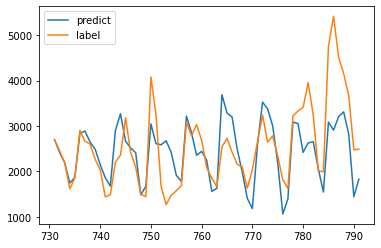

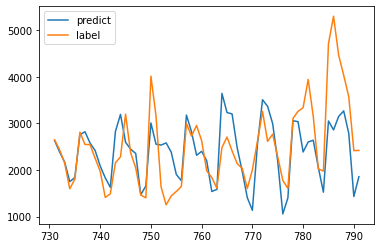

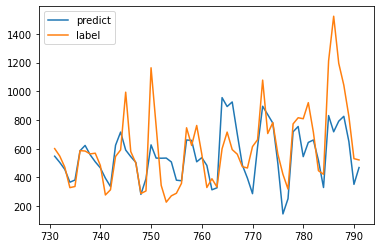

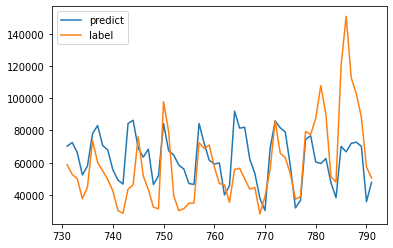

RMSE : 2.988320359695887


In [ ]:
simple.make_val_plot(val, train_split)

In [ ]:
embedded_dim = 256
hidden_size = 256
num_layers = 1
batch_out_p = 0.3

predictor = ModelManager(SimpleLinear, embedded_dim, hidden_size, num_layers, batch_out_p, train_whole, cv=1)
predictor.fit(num_epochs=300, lr=1e-3, log=False)




  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [01:21<00:00, 81.63s/it]


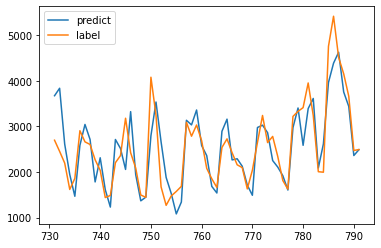

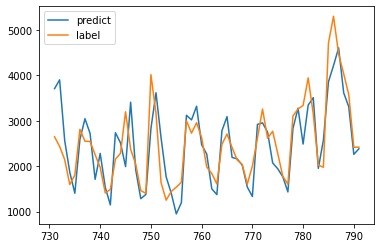

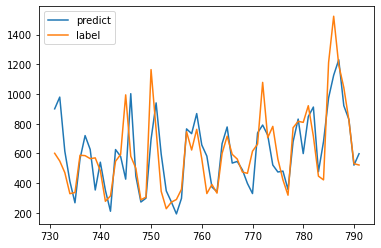

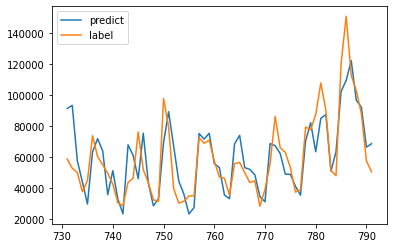

RMSE : 2.2303642692057712


In [ ]:
predictor.make_val_plot(val, train_split)

      DateTime   사용자    세션  신규방문자   페이지뷰
0   2020-11-09  2288  2238    432  71476
1   2020-11-10  2025  2011    411  56929
2   2020-11-11  2100  2069    496  59238
3   2020-11-12  1856  1787    309  56146
4   2020-11-13  2074  2011    359  59771
..         ...   ...   ...    ...    ...
56  2021-01-04  2204  2132    435  54045
57  2021-01-05  2114  2005    369  52298
58  2021-01-06  2100  2019    372  47344
59  2021-01-07  2103  2069    405  48942
60  2021-01-08  1865  1735    258  44625

[61 rows x 5 columns]
saved result


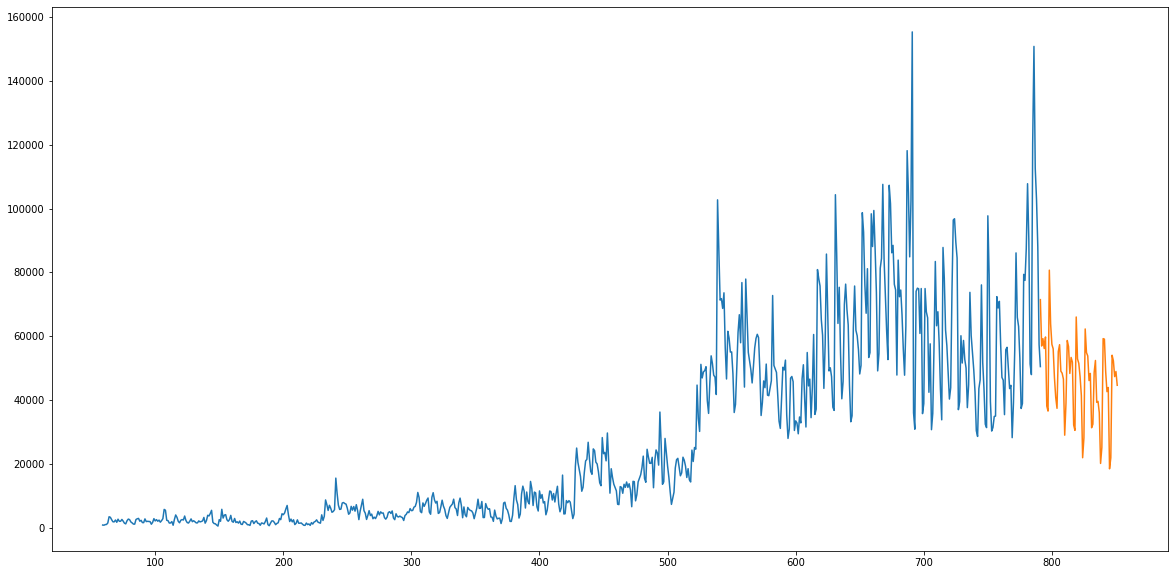

In [ ]:
submission = pd.read_csv("./drive/MyDrive/데이콘/submission.csv", encoding = 'euc-kr') 
submission.iloc[:,1:] = simple.predict(train_whole)
submission.to_csv('submission.csv', index = False, encoding = 'euc-kr')
print(submission)
print('saved result')

submission.columns = ['Date',   '사용자' ,   '세션',  '신규방문자',   '페이지뷰']

def inverse_log(x):
  # 32bit 사용시 단위문제 발생..
  return (np.exp(x)-1).astype(np.int64)

original = train.iloc[:,:5]
mu = (np.exp(train.iloc[:, [5,7,9,11]])-1).values
sigma = (np.exp(train.iloc[:, [6,8,10,12]])-1).values
original.iloc[:,1:] = ((original.iloc[:,1:].values * sigma) + mu).astype(np.int64)
submission.index = [x for x in range(max(original.index), max(original.index)+61)]

plt.figure(figsize=(20,10))
original['페이지뷰'].plot()
submission['페이지뷰'].plot()

# AR model로 만드는게 더좋을듯!!!

#90 in 7 out 밀어서 계속 넣기